In [1]:
import numpy as np
from coupled_phaser import cpr
import Phaser as ph
import forward_model as fm
from miscellaneous import rescale_noise,plot_u,center_u,unpack_obj,extract_data
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
from copy import copy

## Read in data file ##

Insert the name of the data file, interpolated into the sample frame. If you would like to crop voxels uniformly, set __crop__ to the number of voxels you would like to crop from each side in each dimension.

['[0, -2, 0]', '[0, 0, 2]', '[1, -1, -1]', '[1, -1, 1]', '[1, 1, 1]']


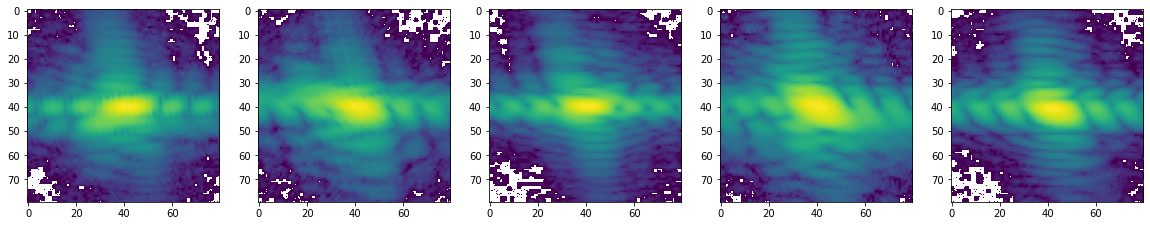

In [2]:
data,qs = extract_data('grain_7_tutorial.h5',crop=10)
data = data[1:]
qs = qs[1:]

## Recipe Instructions ##

There are three options: ER,HIO,SF

recipes is a list of lists, containing two elements each:

First: the phasing method (ER,HI0,SF) followed by the number of iterations
Second: Shrinkwrap option (applied to universal amplitude), a list of two values [sigma,threshold], if no shrinkwrap is wanted, make this element [0]

Every sublist is applied to all constituents and then the constituents are combined to compute the updated guess for $\textbf{u}$ and $\rho$.

#### Example: ####
30 iterations of ER followed by shrinkwrap with sigma 1.0, threshold 0.1 on $\rho$, then 50 iterations of HIO with no shrinkwrap

$[[\text{'ER:30'},[1.0,0.1]],[\text{'HIO:50'},[0]]]$

In [3]:


r1 = 'ER:30'
num_it = 20
recipes = [[r1,[0]] for i in range(num_it)]
for i in range(1,21,3):
    recipes[i] = ['HIO:30',[0]]
for i in range(0,20,3):
    recipes[i] = [r1,[1.0,0.1]]
recipes[-1] = [r1,[1.0,0.1]]

print(recipes)

[['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['ER:30', [1.0, 0.1]]]


## Running Coupled Phase Retrieval ##
for our initial guess, we will set random_start= True, which means that the initial phases will be random values between $-\pi$ and $\pi$ for all of the constituent reconstructions 

2022-06-18 13:07:23.947439: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-18 13:07:24.864285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6120 MB memory:  -> device: 0, name: GeForce RTX 3070, pci bus id: 0000:a1:00.0, compute capability: 8.6
2022-06-18 13:07:24.865166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6108 MB memory:  -> device: 1, name: GeForce RTX 3070, pci bus id: 0000:c1:00.0, compute capability: 8.6
2022-06-18 13:07:25.467159: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. 

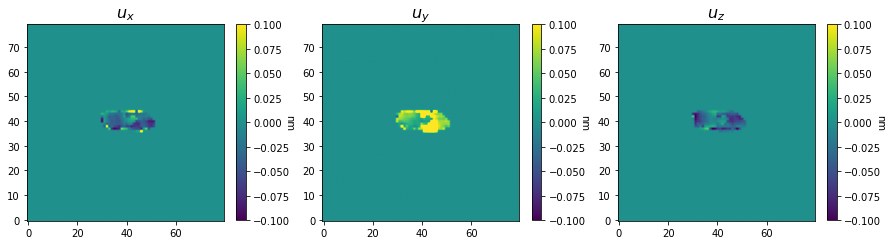

In [4]:
Phaser = cpr(data,qs,0.408,random_start=True)
Phaser.run_recipes(recipes)
obj = Phaser.extract_obj()
uu,amp,supp = unpack_obj(obj)

plot_u(uu,(-0.1,0.1))

## Multi-Phaser GA ##
The GA works exactly the same way. You will need to specify the number of generations, the number of individuals, the recipe for each generation, and the factor by which you would like to cull the population after each generation. The GA inputs are explained in the __run_ga__ docstring. As you will see, this recipe was not very good because the error increased with every generation.

In [5]:
import yaml
num_gen = 4
num_ind = 6
recipe = [['ER:10+HIO:10+ER:5',[1.0,0.1]] for i in range(30)]
recipes = [recipe for i in range(num_gen)]


with open("test_config.yml", 'r') as stream:
    params = yaml.safe_load(stream)
    
params['recipes'] = recipes
params['num_gen'] = num_gen
params['num_ind'] = num_ind

with open("test_config_2.yml", 'w') as outfile:
    yaml.dump(params,outfile)


['[0, -2, 0]', '[0, 0, 2]', '[1, -1, -1]', '[1, -1, 1]', '[1, 1, 1]']


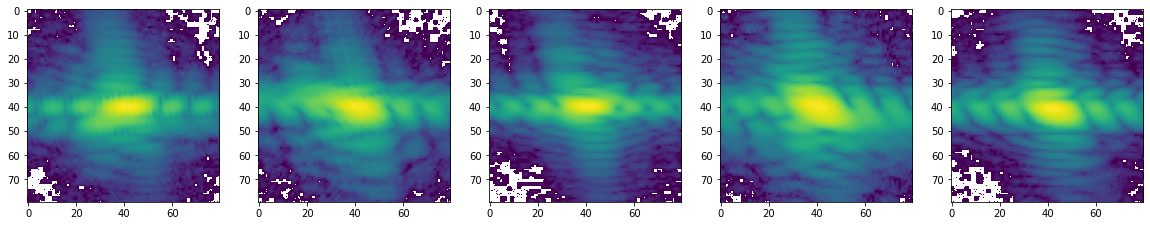

##########################################################################################
Generation: 0
Individual: 0
Time to Reconstruct: 5.28 seconds
L: 0.0006154691 
Chi: 2423226.0 

Individual: 1
Time to Reconstruct: 5.34 seconds
L: 0.00078988366 
Chi: 842888.44 

Individual: 2
Time to Reconstruct: 5.26 seconds
L: 0.0006901253 
Chi: 3383638.5 

Individual 1 Wins


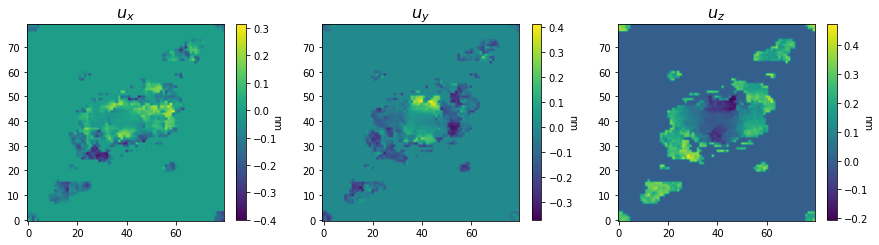

##########################################################################################
Generation: 1
Individual: 0
Time to Reconstruct: 4.61 seconds
L: 0.00019790004 
Chi: 3366117.0 

Individual: 1
Time to Reconstruct: 4.69 seconds
L: 0.00022606128 
Chi: 4170615.8 

Individual: 2
Time to Reconstruct: 4.81 seconds
L: 0.000107550106 
Chi: 2460950.5 

Individual 2 Wins


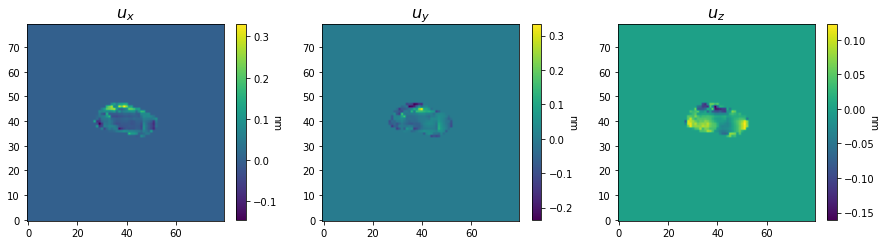

##########################################################################################
Generation: 2
Individual: 0
Time to Reconstruct: 4.86 seconds
L: 0.00013671858 
Chi: 2972084.0 

Individual: 1
Time to Reconstruct: 4.84 seconds
L: 0.000212012 
Chi: 5022432.0 

Individual: 2
Time to Reconstruct: 4.93 seconds
L: 0.00045773396 
Chi: 3648622.2 

Individual 0 Wins


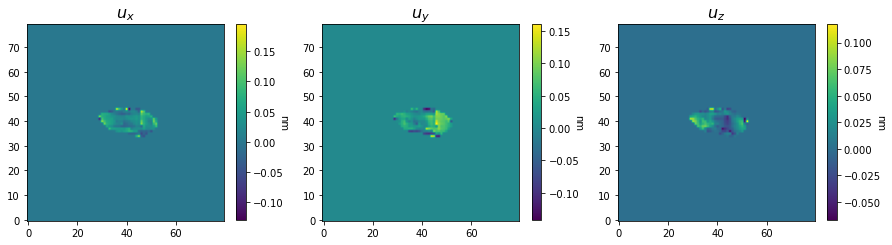

##########################################################################################
Generation: 3
Individual: 0
Time to Reconstruct: 4.92 seconds
L: 0.00014905028 
Chi: 3601049.5 

Individual: 1
Time to Reconstruct: 5.15 seconds
L: 0.00021117723 
Chi: 5357802.5 

Individual: 2
Time to Reconstruct: 5.03 seconds
L: 0.000218129 
Chi: 4334728.5 

Individual 0 Wins


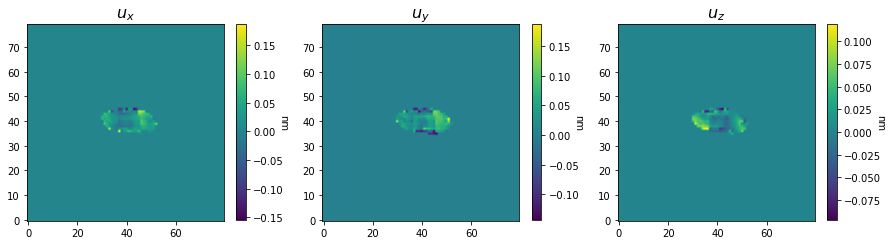

##########################################################################################
Generation: 4
Individual: 0
Time to Reconstruct: 4.87 seconds
L: 0.0001689467 
Chi: 3808203.8 

Individual: 1
Time to Reconstruct: 5.01 seconds
L: 0.0002989213 
Chi: 5472785.0 

Individual: 2
Time to Reconstruct: 4.99 seconds
L: 0.0001991056 
Chi: 5359250.5 

Individual 0 Wins


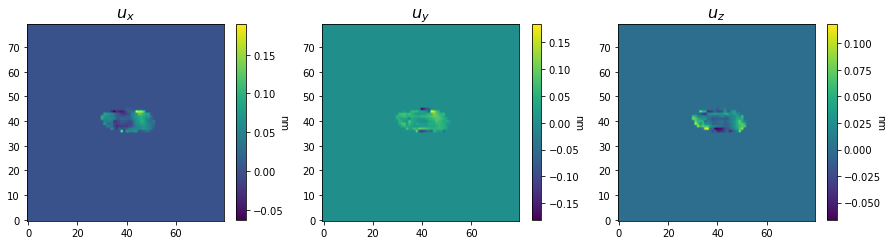

##########################################################################################
Generation: 5
Individual: 0
Time to Reconstruct: 4.94 seconds
L: 0.0002245018 
Chi: 4254389.5 

Individual: 1
Time to Reconstruct: 4.92 seconds
L: 0.00040319428 
Chi: 5634047.5 

Individual: 2
Time to Reconstruct: 4.86 seconds
L: 0.0002629712 
Chi: 5580122.0 

Individual 0 Wins


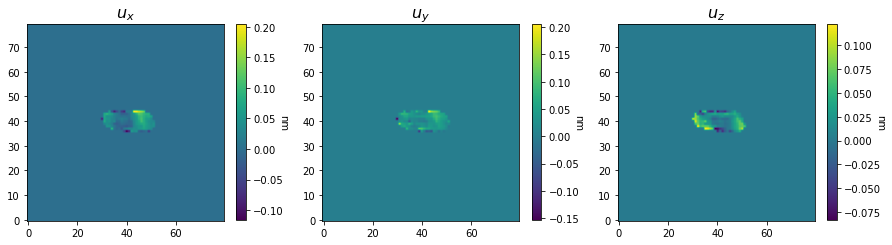

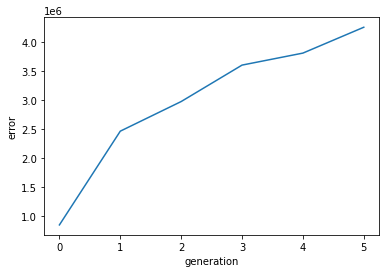

4254389.5


In [6]:
from coupled_phaser_GA import run_ga

vals = run_ga('test_config.yml')

plt.plot(vals['chi'])
plt.xlabel('generation')
plt.ylabel('error')
plt.show()
print(vals['chi'][-1])